In [1]:
import pandas as pd
import yfinance as yf

C:\Users\pc\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\pc\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\pc\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Read the Excel file into a pandas DataFrame, selecting only the first column
df = pd.read_excel("Top Assets.xlsx", usecols=[0])

In [3]:
# Extract the ticker symbols from the DataFrame
tickers = df.values.flatten().tolist()

In [4]:
# Define the window length for calculating z-scores
window_length = 12

In [5]:
# Define the short and long periods for the momentum calculation
short_period = 50
long_period = 200

In [6]:
# Define the number of assets to include in the long and short baskets
basket_size = 15

In [7]:
# Define the start and end dates for the backtest
start_date = "2016-01-01"
end_date = "2021-01-01"

In [8]:
# Retrieve historical data for each ticker separately and concatenate them into a single DataFrame
etf_data = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    data["ticker"] = ticker
    etf_data = pd.concat([etf_data, data])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BRK/B: No timezone found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%******

In [9]:
import numpy as np

# Define parameters
short_period = 4*5*7   # 4 weeks * 5 days/week * 7 periods/day
long_period = 52*5*7   # 52 weeks * 5 days/week * 7 periods/day
lag = 20              # 20-day lag

# Define functions for momentum factors
def slope_trendline(close_prices):
    close_prices = close_prices.fillna(method="ffill")
    if len(close_prices) < 2:
        return np.nan
    x = np.arange(len(close_prices))
    slope, _,  = np.polyfit(x, close_prices, 1)
    return slope

def percent_above_260d_low(close_prices):
    low_260d = close_prices.rolling(window=260, min_periods=1).min()
    return (close_prices - low_260d) / low_260d

def price_oscillator(close_prices):
    short_ma = close_prices.rolling(window=4*5, min_periods=1).mean()
    long_ma = close_prices.rolling(window=52*5, min_periods=1).mean()
    return (short_ma - long_ma) / long_ma

def week39_return(close_prices):
    return close_prices.pct_change(periods=39*5)

def volume_price_trend(close_prices, volume):
    return (close_prices.diff() / close_prices) * volume

# Calculate the price momentum factors for each asset in the ETF
momentum = pd.DataFrame()

for ticker in tickers:
    close_prices = etf_data[etf_data["ticker"] == ticker]["Close"].shift(lag)
    volume = etf_data[etf_data["ticker"] == ticker]["Volume"].shift(lag)
    momentum_factors = pd.DataFrame({
        "slope_trendline": slope_trendline(close_prices),
        "percent_above_260d_low": percent_above_260d_low(close_prices),
        "price_oscillator": price_oscillator(close_prices),
        "week39_return": week39_return(close_prices),
        "volume_price_trend": volume_price_trend(close_prices, volume)
    })
    momentum[ticker] = momentum_factors.mean(axis=1)

etf_data["momentum"] = momentum.mean(axis=1)

C:\Users\pc\AppData\Local\Temp\ipykernel_28340\2536388674.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  momentum[ticker] = momentum_factors.mean(axis=1)
C:\Users\pc\AppData\Local\Temp\ipykernel_28340\2536388674.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  momentum[ticker] = momentum_factors.mean(axis=1)
C:\Users\pc\AppData\Local\Temp\ipykernel_28340\2536388674.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

In [10]:
# Using the price momentum factors, calculate the monthly z-factor score for each asset
etf_data["momentum_mean"] = etf_data.groupby("ticker")["momentum"].rolling(window=window_length).mean().reset_index(0, drop=True)
etf_data["momentum_std"] = etf_data.groupby("ticker")["momentum"].rolling(window=window_length).std().reset_index(0, drop=True)
etf_data["z_factor"] = (etf_data["momentum"] - etf_data["momentum_mean"]) / etf_data["momentum_std"]

In [11]:
# Define a function to select the long and short baskets based on the z-factor scores
def select_baskets(df):
    long_basket = df.nlargest(basket_size, "z_factor")["ticker"].tolist()
    short_basket = df.nsmallest(basket_size, "z_factor")["ticker"].tolist()
    return long_basket, short_basket

In [12]:
# Define a function to calculate the returns for each basket over a given period
def calculate_returns(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    returns = data["Adj Close"].pct_change().fillna(0)
    basket_returns = returns.sum() / len(returns)
    return basket_returns

In [13]:
# Create a list of dates for monthly restructuring
dates = pd.date_range(start_date, end_date, freq="MS").strftime("%Y-%m-%d").tolist()

In [14]:
# Initialize a list to store the returns for each month
monthly_returns = []

In [15]:
# Loop over the dates and calculate the returns for each basket
for i in range(len(dates)-1):
    start_date = dates[i]
    end_date = dates[i+1]
    df = etf_data[(etf_data.index >= start_date) & (etf_data.index < end_date)]
    long_basket, short_basket = select_baskets(df)
    print("Long basket:", long_basket)
    print("Short basket:", short_basket)
    if not long_basket or not short_basket:
        print("Skipping this month due to empty basket(s)")
        continue
    long_returns = calculate_returns(long_basket, start_date, end_date)
    short_returns = calculate_returns(short_basket, start_date, end_date)
    monthly_returns.append(long_returns - short_returns)

Long basket: ['MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT']
Short basket: ['MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT']
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Long basket: ['MSFT', 'AMZN', 'NVDA', 'GOOGL', 'GOOG', 'META', 'UNH', 'XOM', 'JNJ', 'TSLA', 'JPM', 'PG', 'V', 'LLY', 'MA']
Short basket: ['MSFT', 'AMZN', 'NVDA', 'GOOGL', 'GOOG', 'META', 'UNH', 'XOM', 'JNJ', 'TSLA', 'JPM', 'PG', 'V', 'LLY', 'MA']
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
Long basket: ['MSFT', 'AMZN', 'NVDA', 'GOOGL', 'GOOG', 'META', 'UNH', 'XOM', 'JNJ', 'TSLA', 'JPM', 'PG', 'V', 'LLY', 'MA']
Short basket: ['MSFT', 'AMZN', 'NVDA', 'GOOGL', 'GOOG', 'META', 'UNH', 'XOM', 'JN

In [16]:
# Calculate total return and annualized return
total_return = pd.DataFrame(monthly_returns).sum()[0]
annualized_return = ((1 + total_return) ** (12 / len(monthly_returns))) - 1

In [17]:
print("Back Test Annualized Return")
annualized_return

Back Test Annualized Return


AMZN     6.786915e-10
GOOG     6.786915e-10
GOOGL    6.786915e-10
JNJ     -2.210987e-08
JPM     -9.837166e-09
LLY     -6.550134e-09
MA       1.980946e-08
META     6.786915e-10
MSFT     3.897561e-08
NVDA    -1.577761e-08
PG       1.457803e-08
TSLA     6.786915e-10
UNH      1.284519e-08
V        6.567234e-09
XOM     -9.356226e-09
dtype: float64

In [18]:
print("Back Test Total Return")
total_return

Back Test Total Return


AMZN     3.393458e-09
GOOG     3.393458e-09
GOOGL    3.393458e-09
JNJ     -1.105493e-07
JPM     -4.918583e-08
LLY     -3.275067e-08
MA       9.904732e-08
META     3.393458e-09
MSFT     1.948780e-07
NVDA    -7.888804e-08
PG       7.289015e-08
TSLA     3.393458e-09
UNH      6.422596e-08
V        3.283617e-08
XOM     -4.678113e-08
dtype: float64

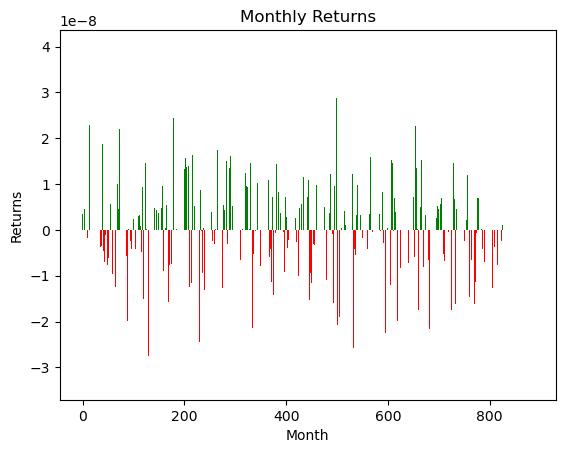

In [58]:
import matplotlib.pyplot as plt
import numpy as np
# PLotting Monthly portfolio return bar chart (pos/neg coloring) 
monthly_returns_flat = []
for item in monthly_returns:
    if isinstance(item, (float, int)):
        monthly_returns_flat.append(item)
    else:
        monthly_returns_flat.extend(item)

monthly_returns_arr = np.array(monthly_returns_flat)

# Define the colors for positive and negative returns
positive_color = 'green'
negative_color = 'red'

# Create a list of colors for each data point based on its value
colors = [positive_color if x >= 0 else negative_color for x in monthly_returns_arr]

# Create a bar chart with colored bars
plt.bar(range(len(monthly_returns_arr)), monthly_returns_arr, color=colors)
plt.title("Monthly Returns")
plt.xlabel("Month")
plt.ylabel("Returns")
plt.show()

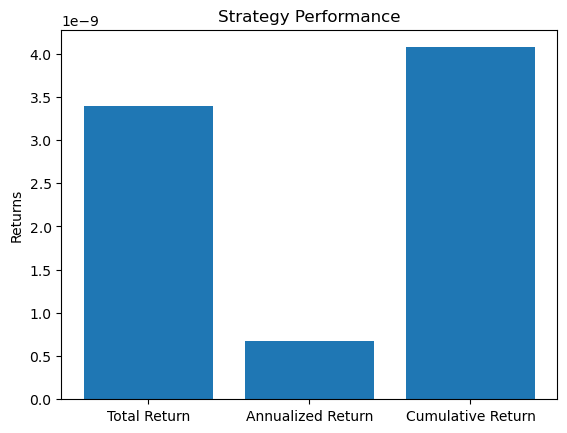

In [53]:
# Create a bar chart of total and annualized returns and cumulative Returns
fig, ax = plt.subplots()
C = total_return + annualized_return
ax.bar(["Total Return", "Annualized Return","Cumulative Return"], [total_return[0], annualized_return[0],C[0]])
ax.set_title("Strategy Performance")
ax.set_ylabel("Returns")
plt.show()

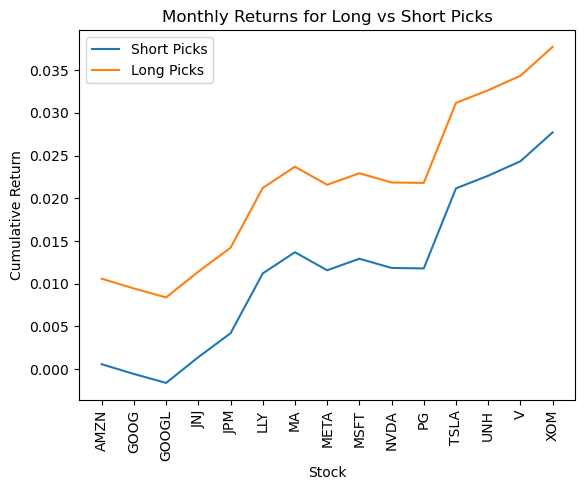

In [55]:
# Assuming long_returns and short_returns are pandas dataframes with monthly returns for long picks and short picks respectively

# Calculate the cumulative returns for each basket
long_cumulative_returns = (1 + long_returns).cumprod() - 1
short_cumulative_returns = (1 + short_returns).cumprod() - 1

# Define an offset for the short picks
offset = 0.01

# Plot the cumulative returns with an offset for the short picks
plt.plot(short_cumulative_returns.index, short_cumulative_returns , label='Short Picks')
plt.plot(long_cumulative_returns.index, long_cumulative_returns + offset, label='Long Picks')
plt.legend()
plt.title('Monthly Returns for Long vs Short Picks')
plt.xlabel('Stock')
plt.ylabel('Cumulative Return')

# Rotate the x-axis labels
plt.xticks(rotation=90)

plt.show()

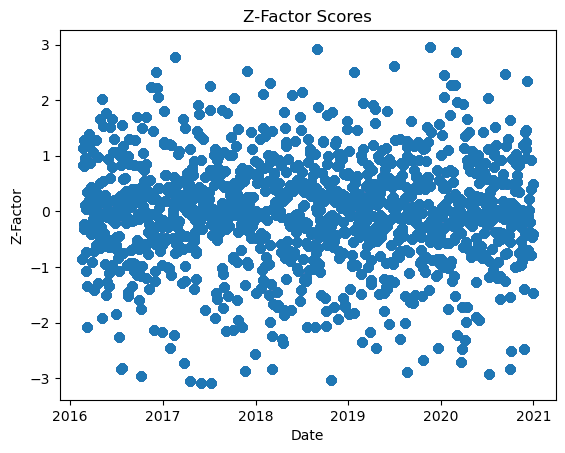

In [59]:
# Create a scatter plot of z-factor scores
plt.scatter(etf_data.index, etf_data["z_factor"])
plt.title("Z-Factor Scores")
plt.xlabel("Date")
plt.ylabel("Z-Factor")
plt.show()